# this notebook will perform a hierarchical clustering on the relevance maps

Written by Angela Tam & CBIG under MIT license: https://github.com/ThomasYeoLab/CBIG/blob/master/LICENSE.md

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import stats
import scipy.cluster.hierarchy as sch
import os

In [2]:
# set random seed
np.random.seed(seed=1)

In [3]:
# function to perform a clustering and plot a correlation matrix and dendrogram
def cluster_mat(array, list_var, pdist_metric, link_metric, c_dict, thresh=3, path_out=None, fname=None):
    df = pd.DataFrame(data=array, columns=list_var)
    df_corr = df[list_var].corr()
    df_h = df_corr.copy()
    corr = df_h.values
    # perform the clustering
    # see sch.distance.pdist function for acceptable values for metric
    pdist = sch.distance.pdist(corr, metric=pdist_metric)
    # see sch.linkage function for acceptable values for method and metric
    linkage = sch.linkage(pdist, method=link_metric, metric=pdist_metric)
    idx = sch.fcluster(linkage, t=3, criterion='maxclust')
    
    # plot dendrogram
    plt.figure(figsize=(12,4))
    plt.ylabel('distance')
    r = sch.dendrogram(linkage, color_threshold=thresh, labels=list_var, leaf_rotation=90)
    ax = plt.gca()
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(c_dict[lbl.get_text()])
    if isinstance(path_out, str):
        plt.savefig(path_out + '/dendrogram_' + fname + '.pdf')
    
    # plot rearranged clustered correlation matrix
    cols = r['ivl']
    df_h = df_h.reindex_axis(cols,axis=1)
    df_h = df_h.reindex_axis(cols,axis=0)
    #plt.figure(figsize=(25,18.75))
    plt.figure(figsize=(10,8))
    g = sns.heatmap(df_h, vmin=-0.8, vmax=0.8, cmap="BrBG",
            xticklabels=df_h.columns,
            yticklabels=df_h.columns)
    for tick_label in g.get_yticklabels():
        tick_text = tick_label.get_text()
        tick_label.set_color(c_dict[tick_text])
    for tick_label in g.get_xticklabels():
        tick_text = tick_label.get_text()
        tick_label.set_color(c_dict[tick_text])
    if isinstance(path_out, str):
        plt.savefig(path_out + '/sim_matrix_' + fname + '.pdf')
    return idx, df_h, pdist, cols

In [4]:
# function to plot a correlation matrix without clustering
# size is a tuple e.g.(10,8)
def plot_raw_matrix(array, list_var, c_dict, size, path_out, fname):
    df = pd.DataFrame(data=array, columns=list_var)
    df_corr = df[list_var].corr()
    plt.figure(figsize=size)
    g = sns.heatmap(df_corr, vmin=-0.8, vmax=0.8, cmap="BrBG",
               xticklabels=df_corr.columns,
               yticklabels=df_corr.columns)
    for tick_label in g.get_yticklabels():
        tick_text = tick_label.get_text()
        tick_label.set_color(c_dict[tick_text])
    for tick_label in g.get_xticklabels():
        tick_text = tick_label.get_text()
        tick_label.set_color(c_dict[tick_text])
    if isinstance(path_out, str):
        plt.savefig(path_out + '/sim_matrix_' + fname + '.pdf')

In [5]:
def rearrange_matrix_sig(array, idx):
    nn = 0
    new_mat = np.zeros((array.shape[0], len(idx)))
    for i in idx:
        new_mat[:,nn] = array[:,i]
        nn += 1
    return new_mat

### SET OUTPUT DIRECTORY

In [6]:
# set output directory, default is None - no output will be saved unless changed
path_out = None

### set up variables

In [7]:
# input directory
in_dir = os.getenv('CBIG_CODE_DIR') + '/stable_projects/predict_phenotypes/ChenTam2021_TRBPC/figure_utilities/input'

In [8]:
# replication directory
rep_dir = os.getenv('CBIG_REPDATA_DIR') + '/stable_projects/predict_phenotypes/ChenTam2021_TRBPC/figures'

In [9]:
# get a list of all predicted variables/outcomes
list_var = []
with open(in_dir + '/variables_to_predict.txt') as file:
    for line in file:
        line = line.strip()
        list_var.append(line)

In [10]:
# list of behaviors that were significantly predicted
list_sig_r = ['vocabulary','working memory','reading',
              'crystallized cognition','attention','overall cognition',
              'executive function','fluid cognition','processing speed',
              'episodic memory','short delay recall','long delay recall',
              'fluid intelligence','visuospatial accuracy','visuospatial efficiency',
              'visuospatial reaction time','lack of planning','sensation seeking',
              'lack perseverance','negative urgency','positive urgency',
              'behavioral inhibition','fun seeking','reward responsiveness',
              'drive','total psychosis symptoms','psychosis severity',
              'somatic complaints','thought problems','attention problems',
              'anxious depressed','social problems']

In [11]:
# get indices from original list (list_var) that match the list of significant scores
idx_sig = [list_var.index(i) for i in list_sig_r]

In [12]:
# dictionary for colours of different behavioural scales
c_dict = {'vocabulary':'red',
          'attention':'red',
          'working memory':'red',
          'executive function':'red',
          'processing speed':'red',
          'episodic memory':'red',
          'reading':'red',
          'fluid cognition':'red',
          'crystallized cognition':'red',
          'overall cognition':'red',
          'short delay recall':'firebrick',
          'long delay recall':'firebrick',
          'fluid intelligence':'orangered',
          'visuospatial accuracy':'lightcoral',
          'visuospatial reaction time':'lightcoral',
          'visuospatial efficiency':'lightcoral',
          'anxious depressed':'blue',
          'withdrawn depressed':'blue',
          'somatic complaints':'blue',
          'social problems':'blue',
          'thought problems':'blue',
          'attention problems':'blue',
          'rulebreaking behavior':'blue',
          'aggressive behavior':'blue',
          'total psychosis symptoms':'cornflowerblue',
          'psychosis severity':'cornflowerblue',
          'mania severity':'dodgerblue',
          'negative urgency':'black',
          'lack of planning':'black',
          'sensation seeking':'black',
          'positive urgency':'black',
          'lack perseverance':'black',
          'behavioral inhibition':'dimgrey',
          'reward responsiveness':'dimgrey',
          'drive':'dimgrey',
          'fun seeking':'dimgrey'}

## cluster when all the fmri conditions are stacked together

In [13]:
# load the data
mat_stack = sio.loadmat(rep_dir + '/stacked_relevance_vectors.mat')

In [14]:
mat_stack['stack'].shape

(350284, 36)

In [15]:
# take only the significant scores and rearrange
stacked_mat = rearrange_matrix_sig(mat_stack['stack'], idx_sig)

In [16]:
stacked_mat.shape

(350284, 32)

#### do clustering and plot

/data/users/atam/miniconda/envs/xps13_main/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
/data/users/atam/miniconda/envs/xps13_main/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


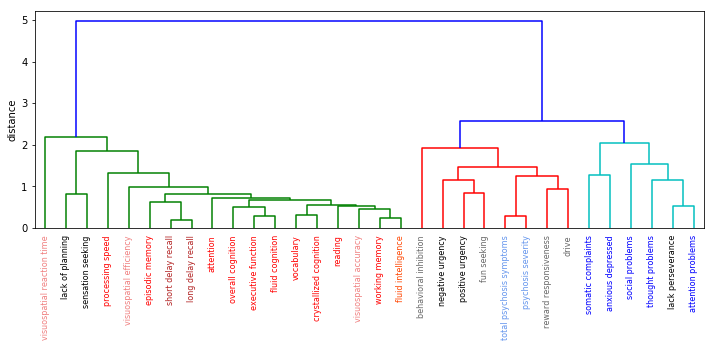

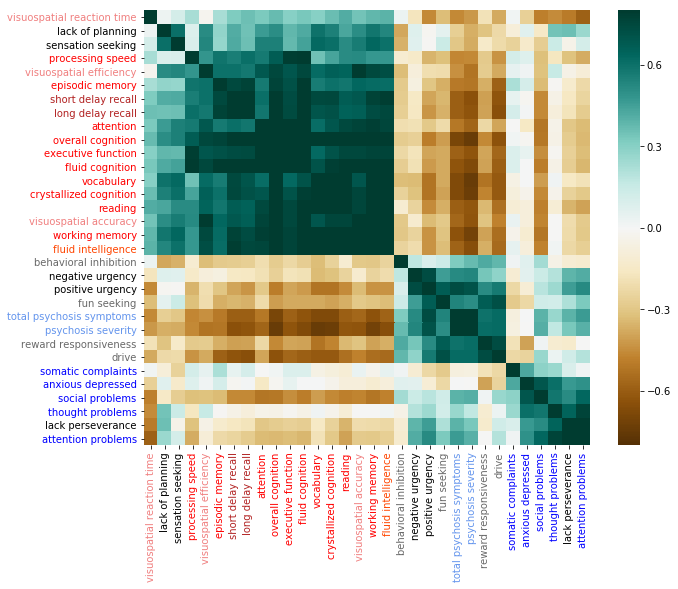

In [17]:
#plt.rcParams.update({'font.size': 22})
[stacked_idx, stacked_df_h, pdist, cols]=cluster_mat(stacked_mat,
                                                    list_sig_r,
                                                    'euclidean',
                                                    'average',
                                                    c_dict,2.2,path_out,'datadriven_stacked')

In [18]:
# this is the order of the clustered items from above
cols

['visuospatial reaction time',
 'lack of planning',
 'sensation seeking',
 'processing speed',
 'visuospatial efficiency',
 'episodic memory',
 'short delay recall',
 'long delay recall',
 'attention',
 'overall cognition',
 'executive function',
 'fluid cognition',
 'vocabulary',
 'crystallized cognition',
 'reading',
 'visuospatial accuracy',
 'working memory',
 'fluid intelligence',
 'behavioral inhibition',
 'negative urgency',
 'positive urgency',
 'fun seeking',
 'total psychosis symptoms',
 'psychosis severity',
 'reward responsiveness',
 'drive',
 'somatic complaints',
 'anxious depressed',
 'social problems',
 'thought problems',
 'lack perseverance',
 'attention problems']

### correlations between behavioral categories

In [19]:
# cognition & cognition (lower triangle, no diagonal)
cog_tril = np.tril(stacked_df_h.loc['visuospatial reaction time':'fluid intelligence',
                                   'visuospatial reaction time':'fluid intelligence'].values,-1)
cog_tril[np.nonzero(cog_tril)].mean()

0.6297207450199659

In [20]:
# cognition & personality block
stacked_df_h.loc['visuospatial reaction time':'fluid intelligence',
                 'behavioral inhibition':'drive'].values.mean()

-0.3793944335367476

In [21]:
# cognition & mental health block
stacked_df_h.loc['visuospatial reaction time':'fluid intelligence',
                 'somatic complaints':'attention problems'].values.mean()

-0.1515718243296048

In [22]:
# personality & personality (lower triangle, no diagonal)
pers_tril = np.tril(stacked_df_h.loc['behavioral inhibition':'drive',
                                   'behavioral inhibition':'drive'].values,-1)
pers_tril[np.nonzero(pers_tril)].mean()

0.5215801823779455

In [23]:
# personality & mental health block
stacked_df_h.loc['behavioral inhibition':'drive',
                 'somatic complaints':'attention problems'].values.mean()

0.09600527603792186

In [24]:
# mental health & mental health (lower triangle, no diagonal)
mh_tril = np.tril(stacked_df_h.loc['somatic complaints':'attention problems',
                                   'somatic complaints':'attention problems'].values,-1)
mh_tril[np.nonzero(mh_tril)].mean()

0.4872792943913299

## giant matrix of all behavioural maps across all conditions 

In [25]:
# get the indices of cols from list_var
idx_cols = [list_var.index(i) for i in cols]

In [26]:
# load data
mat_fc = sio.loadmat(rep_dir + '/relevance_vectors.mat')

In [27]:
# rearrange each fMRI matrix according to the clustering from the stacked matrix (all 4 fMRI vectors together)
rs_mat_s = rearrange_matrix_sig(mat_fc['struct_fc_vec']['rs'][0][0], idx_cols)
mid_mat_s = rearrange_matrix_sig(mat_fc['struct_fc_vec']['mid'][0][0], idx_cols)
nback_mat_s = rearrange_matrix_sig(mat_fc['struct_fc_vec']['nback'][0][0], idx_cols)
sst_mat_s = rearrange_matrix_sig(mat_fc['struct_fc_vec']['sst'][0][0], idx_cols)

In [28]:
# create np array with all the vectors ordered by behavior and then fmri condition
concat_mat_clus = np.zeros((87571, 128))
nn = 0
for bb in range(rs_mat_s.shape[1]): # for each sig. behavior
    concat_mat_clus[:,nn] = rs_mat_s[:,bb] # put in rs
    nn += 1
    concat_mat_clus[:,nn] = mid_mat_s[:,bb] # put in mid
    nn += 1
    concat_mat_clus[:,nn] = sst_mat_s[:,bb] # put in sst
    nn += 1
    concat_mat_clus[:,nn] = nback_mat_s[:,bb] # put in nback
    nn += 1

In [29]:
concat_mat_clus.shape

(87571, 128)

#### set up dictionary for coloring labels

In [30]:
list_fmri = ['REST ', 'MID ', 'SST ', 'NBACK ']
list_sig_r_fmri_clus = []
for behav in cols:
    for fmri in list_fmri:
        tmp = fmri + behav
        list_sig_r_fmri_clus.append(tmp)

In [31]:
colours = ['lightcoral', #'visuospatial reaction time',
           'black', #'lack of planning',
           'black', #'sensation seeking',
           'red', #'processing speed',
           'lightcoral', #'visuospatial efficiency',
           'red', #'episodic memory',
           'firebrick', #'short delay recall',
           'firebrick', #'long delay recall',
           'red', #'attention',
           'red', #'overall cognition',
           'red', #'executive function',
           'red', #'fluid cognition',
           'red', #'vocabulary',
           'red', #'crystallized cognition',
           'red', #'reading',
           'lightcoral', #'visuospatial accuracy',
           'red', #'working memory',
           'orangered', #'fluid intelligence',
           'dimgrey', #'behavioral inhibition',
           'black', #'negative urgency',
           'black', #'positive urgency',
           'dimgrey', #'fun seeking',
           'cornflowerblue', #'total psychosis symptoms',
           'cornflowerblue', #'psychosis severity',
           'dimgrey', #'reward responsiveness',
           'dimgrey', #'drive',
           'blue', #'somatic complaints',
           'blue', #'anxious depressed',
           'blue', #'social problems',
           'blue', #'thought problems',
           'black', #'lack perseverance',
           'blue'] #'attention problems'

In [32]:
colours_fmri = []
for cc in colours:
    colours_fmri.append(cc)
    colours_fmri.append(cc)
    colours_fmri.append(cc)
    colours_fmri.append(cc)

In [33]:
fmri_c_dict = dict(zip(list_sig_r_fmri_clus, colours_fmri))

#### plot

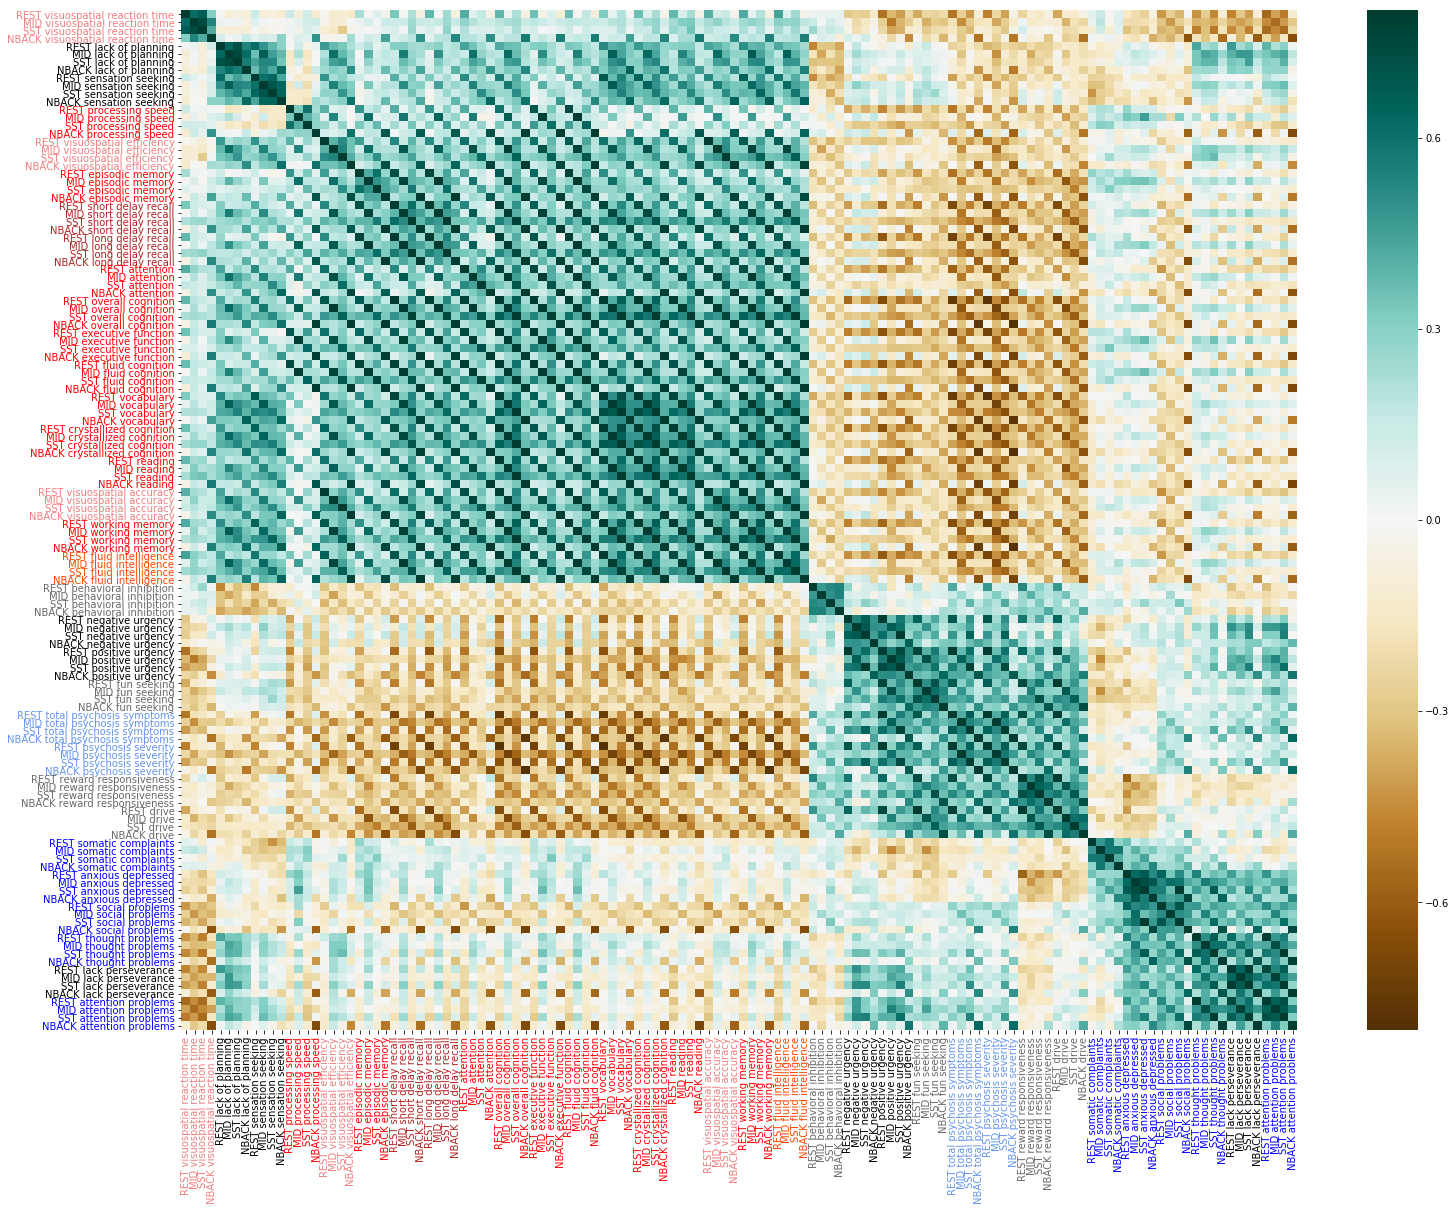

In [34]:
plt.rcParams.update({'font.size': 10})
plot_raw_matrix(concat_mat_clus, list_sig_r_fmri_clus, fmri_c_dict, (25,18.75), path_out, 'datadriven_ind')